In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import os 
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms 
from torch.utils.data import DataLoader

# Step 1: Forward Process = Adding Noise

In [2]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    # Ensure t matches the current batch size of x_0
    current_batch_size = x_0.shape[0]
    if t.shape[0] != current_batch_size:
        t = t[:current_batch_size]  # Adjust t to the current batch size
    
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    # mean + variance
    # print("sqrt_alphas_cumprod_t shape:", sqrt_alphas_cumprod_t.shape)
    # print("x_0 shape:", x_0.shape)
    # print("sqrt_one_minus_alphas_cumprod_t shape:", sqrt_one_minus_alphas_cumprod_t.shape)
    # print("noise shape:", noise.shape)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# DEFINE BETA SCHEDULE
T = 300
betas = linear_beta_schedule(timesteps=T)

# PRE-CALCULATE DIFFERENT TERMS FOR CLOSED FORM
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

#### Create dataset of video frames

In [3]:
class FireFrameDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.frame_dir = os.path.join(data_dir, "frames")
        self.transform = transform
        self.file_list = os.listdir(self.frame_dir)
        
        self.images = []
        for file_name in self.file_list:
            file_path = os.path.join(self.frame_dir, file_name)
            with open(file_path, 'rb') as f:
                images = pickle.load(f)

            # Normalize images and flatten them
            images = np.array(images)  # shape: (20, 128, 128)
            images = images.astype(np.float32)  # normalize pixel values
            # images = images.reshape(-1, 128, 128)  # shape: (20, 128, 128)
            self.images.extend(images)
        
    def __len__(self):
        return len(self.images) - 1
    
    def __getitem__(self, idx):
        current_image = self.images[idx]
        # Handle wrap-around for the last index
        next_idx = (idx + 1) % len(self.images)
        next_image = self.images[next_idx]

        # Convert numpy arrays to PyTorch tensors
        current_image_tensor = torch.from_numpy(current_image)
        next_image_tensor = torch.from_numpy(next_image)

        # Apply transformations if provided
        if self.transform:
            current_image_tensor = self.transform(current_image_tensor)
            next_image_tensor = self.transform(next_image_tensor)

        return current_image_tensor, next_image_tensor
    
data_dir = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data"
data_transforms = [
        # transforms.RandomHorizontalFlip(),
        # transforms.ToTensor(), # scale to [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # scale to [-1,1]
    ]
    
data_transform = transforms.Compose(data_transforms)
dataset = FireFrameDataset(data_dir)        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


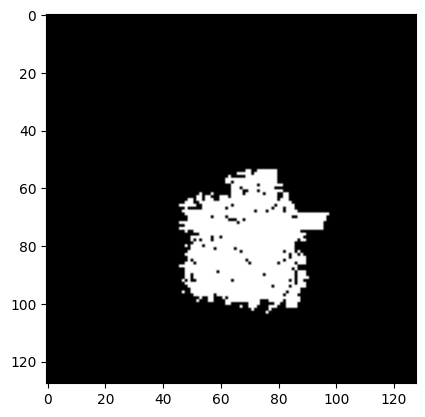

In [6]:

plt.imshow(dataset[55][0].numpy())
print(type(dataset[55][0]))

In [7]:
# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader for iterating over the dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Apply forward pass on Dataset

In [19]:
IMG_SIZE = 128
BATCH_SIZE = 32

def show_tensor_image(image):
    reverse_transform = transforms.Compose([
        # transforms.Lambda(lambda t: (t + 1) / 2),
        # transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        # transforms.Lambda(lambda t: t  * 255.),
        transforms.Lambda(lambda t: t.numpy()),
        # transforms.ToPILImage(),
    ])
    
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transform(image), cmap='gray_r')

torch.Size([32, 128, 128, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


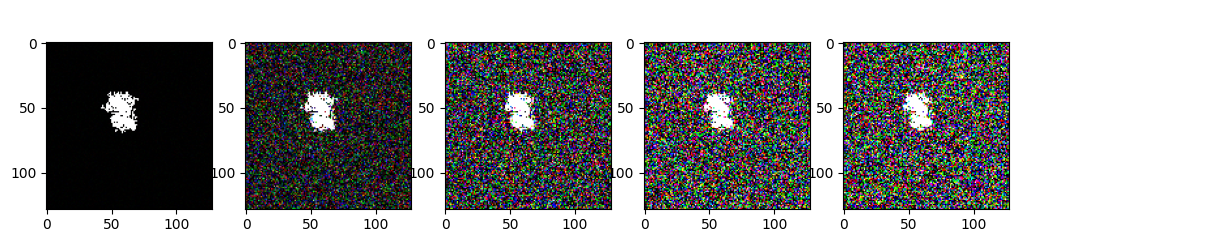

In [20]:
image = next(iter(train_loader))[0]
# image = image.unsqueeze(1)
print(image.shape)

plt.figure(figsize=(15, 3))
plt.axis('off')
num_images = 5
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

torch.Size([32, 1, 128, 128])
sqrt_alphas_cumprod_t shape: torch.Size([1, 1, 1, 1])
x_0 shape: torch.Size([32, 1, 128, 128])
sqrt_one_minus_alphas_cumprod_t shape: torch.Size([1, 1, 1, 1])
noise shape: torch.Size([32, 1, 128, 128])
sqrt_alphas_cumprod_t shape: torch.Size([1, 1, 1, 1])
x_0 shape: torch.Size([32, 1, 128, 128])
sqrt_one_minus_alphas_cumprod_t shape: torch.Size([1, 1, 1, 1])
noise shape: torch.Size([32, 1, 128, 128])
sqrt_alphas_cumprod_t shape: torch.Size([1, 1, 1, 1])
x_0 shape: torch.Size([32, 1, 128, 128])
sqrt_one_minus_alphas_cumprod_t shape: torch.Size([1, 1, 1, 1])
noise shape: torch.Size([32, 1, 128, 128])
sqrt_alphas_cumprod_t shape: torch.Size([1, 1, 1, 1])
x_0 shape: torch.Size([32, 1, 128, 128])
sqrt_one_minus_alphas_cumprod_t shape: torch.Size([1, 1, 1, 1])
noise shape: torch.Size([32, 1, 128, 128])
sqrt_alphas_cumprod_t shape: torch.Size([1, 1, 1, 1])
x_0 shape: torch.Size([32, 1, 128, 128])
sqrt_one_minus_alphas_cumprod_t shape: torch.Size([1, 1, 1, 1])
noi

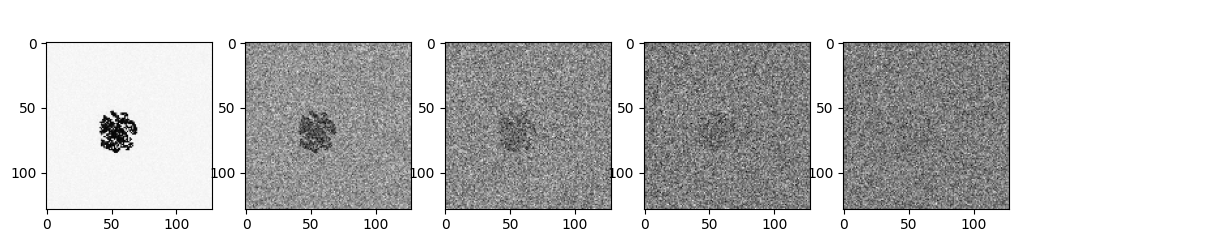

In [142]:
image = next(iter(train_loader))[0]
image = image.unsqueeze(1)
print(image.shape)

plt.figure(figsize=(15, 3))
plt.axis('off')
num_images = 5
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

# Step 2 : Backward Process - UNet 

In [147]:
import torch.nn as nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        # time_emb = time_emb[(..., ) + (None, ) * 2]
        
        # Ensure time_emb can be reshaped appropriately
        expected_num_elements = x.shape[0] * self.time_mlp.out_features
        if time_emb.numel() != expected_num_elements:
            raise ValueError(f"Expected {expected_num_elements} elements, but got {time_emb.numel()} elements in time_emb")
        
        # Dynamically reshape time_emb to match the batch size of x
        time_emb = time_emb.view(x.shape[0], self.time_mlp.out_features, 1, 1)
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)
    

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1 
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32
        
        # Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        # Initial Projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        
        # Downsample
        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)
        ])
        
        # Upsample
        self.ups = nn.ModuleList([
            Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)
        ])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)
        
    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)
        
        # Initial Conv
        x = self.conv0(x)
        
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        
        return self.output(x)
    
model = Unet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model        

Num params:  62437601


Unet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Co

# Step 3 : The Loss Function

In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    x_noisy = x_noisy.unsqueeze(1)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

#### SAMPLING

In [145]:
torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 
    
@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 1, img_size, img_size), device=device)
    plt.figure(figsize=(15,3))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

#### TRAINING

sqrt_alphas_cumprod_t shape: torch.Size([32, 1, 1])
x_0 shape: torch.Size([32, 128, 128])
sqrt_one_minus_alphas_cumprod_t shape: torch.Size([32, 1, 1])
noise shape: torch.Size([32, 128, 128])


C:\Users\Anirbit\AppData\Local\Temp\ipykernel_10952\879220651.py:6: UserWarning: Using a target size (torch.Size([32, 1, 128, 128])) that is different to the input size (torch.Size([32, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(noise, noise_pred)


Epoch 0 | step 000 Loss: 0.8102779388427734 


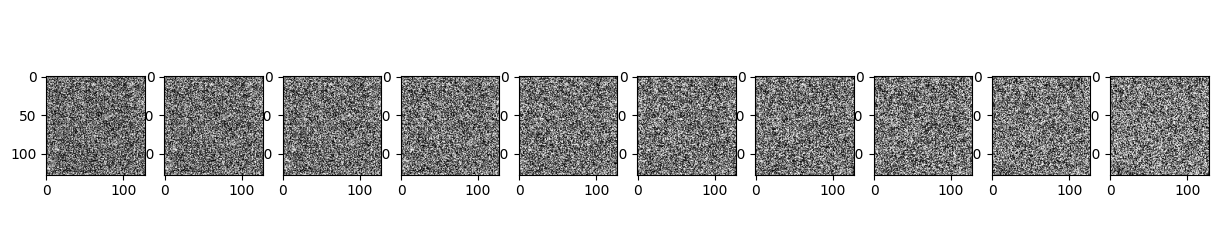

sqrt_alphas_cumprod_t shape: torch.Size([32, 1, 1])
x_0 shape: torch.Size([32, 128, 128])
sqrt_one_minus_alphas_cumprod_t shape: torch.Size([32, 1, 1])
noise shape: torch.Size([32, 128, 128])
sqrt_alphas_cumprod_t shape: torch.Size([32, 1, 1])
x_0 shape: torch.Size([32, 128, 128])
sqrt_one_minus_alphas_cumprod_t shape: torch.Size([32, 1, 1])
noise shape: torch.Size([32, 128, 128])
sqrt_alphas_cumprod_t shape: torch.Size([32, 1, 1])
x_0 shape: torch.Size([32, 128, 128])
sqrt_one_minus_alphas_cumprod_t shape: torch.Size([32, 1, 1])
noise shape: torch.Size([32, 128, 128])
sqrt_alphas_cumprod_t shape: torch.Size([32, 1, 1])
x_0 shape: torch.Size([32, 128, 128])
sqrt_one_minus_alphas_cumprod_t shape: torch.Size([32, 1, 1])
noise shape: torch.Size([32, 128, 128])
sqrt_alphas_cumprod_t shape: torch.Size([32, 1, 1])
x_0 shape: torch.Size([32, 128, 128])
sqrt_one_minus_alphas_cumprod_t shape: torch.Size([32, 1, 1])
noise shape: torch.Size([32, 128, 128])
sqrt_alphas_cumprod_t shape: torch.Size(

ValueError: Expected 1920 elements, but got 4096 elements in time_emb

In [148]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()